# Tips Prediction - Modeling<a id='Tips_Prediction_-_Modeling'></a>

## 1. Contents <a id='1._Contents'></a>
* [Tips Prediction - Modeling](#Tips_Prediction_-_Modeling)
  * [1. Contents](#1._Contents)
  * [2. Sourcing and Loading](#2._Sourcing_and_Loading)
    * [2a. Import relevant libraries](#2a._Import_relevant_libraries)
    * [2b. Load DataFrame](#2b._Load_DataFrame)
  * [3. `tip` model](#3._`tip`_model)
    * [3a. Best features for linear regression](#3a._Best_features_for_linear_regression)
    * [3b. Best feature for Random Forest regression](#3b._Best_features_for_Random_Forest_regression)
    * [3c. Model Selection](#3c._Model_Selection)
  * [4. Model Evaluations](#5._Model_Evaluations)
    * [4a. Evaluation scatterplots](#5a._Evaluation_scatterplots)
    * [4b. R-Squared](#5b._R-Squared)
    * [4c. Residuals plots](#4c._Residuals_plots)
    * [4d. Comparison with simple model based on the mean](#4d._Comparison_with_simple_model_based_on_mean)
  * [5. Conclusion and Future Work](#6._Conclusion_and_Future_Work)

## 2. Sourcing and Loading<a id='2._Sourcing_and_Loading'></a>

### 2a. Import relevant libraries<a id='2a._Import_relevant_libraries'></a>

In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import kaggle as kg
import pandas as pd
import missingno as msno
import statsmodels.api as sm
import scipy.stats
from matplotlib.lines import Line2D
from matplotlib import rcParams
sns.set_style("whitegrid")
sns.set_context("poster")
from kaggle.api.kaggle_api_extended import KaggleApi
from statsmodels.graphics.api import abline_plot
from sklearn.metrics import mean_squared_error, r2_score, classification_report, confusion_matrix, accuracy_score, \
plot_roc_curve, roc_curve, roc_auc_score, precision_recall_curve, auc, mean_absolute_error
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve, cross_val_score
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn import linear_model, preprocessing
from sklearn.feature_selection import SelectKBest, f_regression
from zipfile import ZipFile
from scipy import stats
from scipy.stats import t
from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu
from numpy.random import seed
from yellowbrick.datasets import load_concrete
from yellowbrick.regressor import ResidualsPlot
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

### 2b. Load DataFrame<a id='2b._Load_DataFrame'></a>

In [17]:
df = pd.read_csv('df.csv', index_col=0)
df.head()

,total_bill,tip,size,perc,sex_Male,smoker_Yes,day_Sat,day_Sun,day_Thur,time_Lunch
0,16.99,1.01,2,5.944673,0,0,0,1,0,0
1,10.34,1.66,3,16.054159,1,0,0,1,0,0
2,21.01,3.50,3,16.658734,1,0,0,1,0,0
3,23.68,3.31,2,13.978041,1,0,0,1,0,0
4,24.59,3.61,4,14.680765,0,0,0,1,0,0


In [18]:
df.shape

(244, 10)

## 3. `tip` Model<a id='3._`tip`_model'></a>

### 3a. Best features for linear regression<a id='3a._Best_features_for_linear_regression'></a>

In [19]:
X_cols = [col for col in df.columns if col not in ['tip','perc']]

X = df[X_cols]
y = df['tip']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

X_train = X_train.sample(10000, random_state=42, replace=True)
y_train = y_train.sample(10000, random_state=42, replace=True)
X_test = X_test.sample(1000, random_state=42, replace=True)
y_test = y_test.sample(1000, random_state=42, replace=True)

k = [k+1 for k in range(len(X_train.columns))]
grid_params = {'selectkbest__k': k}
lr = LinearRegression()

pipe = make_pipeline(
    StandardScaler(),
    SelectKBest(f_regression),
    LinearRegression()
)

tip_lr_grid = GridSearchCV(pipe, param_grid=grid_params, cv=5, n_jobs=-1)
tip_lr_grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('selectkbest',
                                        SelectKBest(score_func=<function f_regression at 0x000001A5520BF940>)),
                                       ('linearregression',
                                        LinearRegression())]),
             n_jobs=-1,
             param_grid={'selectkbest__k': [1, 2, 3, 4, 5, 6, 7, 8]})

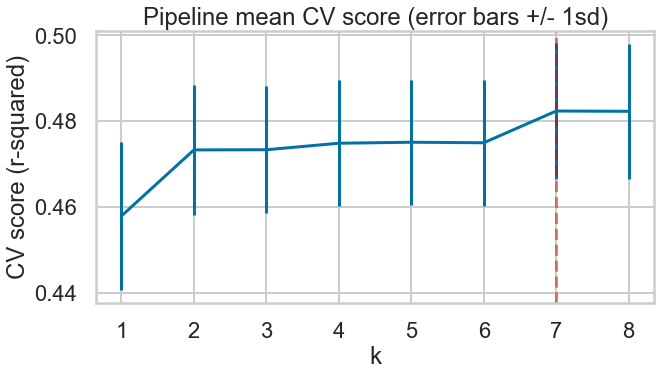

In [20]:
score_mean = tip_lr_grid.cv_results_['mean_test_score']
score_std = tip_lr_grid.cv_results_['std_test_score']
cv_k = [k for k in tip_lr_grid.cv_results_['param_selectkbest__k']]

best_k = tip_lr_grid.best_params_['selectkbest__k']
plt.subplots(figsize=(10, 5))
plt.errorbar(cv_k, score_mean, yerr=score_std)
plt.axvline(x=best_k, c='r', ls='--', alpha=.5)
plt.xlabel('k')
plt.ylabel('CV score (r-squared)')
plt.title('Pipeline mean CV score (error bars +/- 1sd)');

In [21]:
selected = tip_lr_grid.best_estimator_.named_steps.selectkbest.get_support()
coefs = tip_lr_grid.best_estimator_.named_steps.linearregression.coef_
features = X_train.columns[selected]
pd.Series(coefs, index=features).sort_values(ascending=False)

total_bill    0.811254
size          0.171726
time_Lunch    0.107325
day_Sun       0.015195
sex_Male     -0.027000
day_Thur     -0.076490
smoker_Yes   -0.124998
dtype: float64

Based on our Grid Search, a linear regression model using **7 features** is our most accurate model.

### 3b. Best features for Random Forest regression<a id='3b._Best_features_for_Random_Forest_regression'></a>

In [22]:
n_est = [int(n) for n in np.logspace(start=1, stop=3, num=5)]
grid_params = {
        'randomforestregressor__n_estimators': n_est,
        'standardscaler': [StandardScaler(), None],
}
grid_params

{'randomforestregressor__n_estimators': [10, 31, 100, 316, 1000],
 'standardscaler': [StandardScaler(), None]}

In [23]:
rf_pipe = make_pipeline(
    StandardScaler(),
    RandomForestRegressor()
)

X_cols = [col for col in df.columns if col not in ['tip','perc']]

X = df[X_cols]
y = df['tip']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

X_train = X_train.sample(10000, random_state=42, replace=True)
y_train = y_train.sample(10000, random_state=42, replace=True)
X_test = X_test.sample(1000, random_state=42, replace=True)
y_test = y_test.sample(1000, random_state=42, replace=True)

tip_rf_grid = GridSearchCV(rf_pipe, param_grid=grid_params, cv=5, n_jobs=-1)
tip_rf_grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('randomforestregressor',
                                        RandomForestRegressor())]),
             n_jobs=-1,
             param_grid={'randomforestregressor__n_estimators': [10, 31, 100,
                                                                 316, 1000],
                         'standardscaler': [StandardScaler(), None]})

In [24]:
tip_rf_grid.best_estimator_

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestregressor',
                 RandomForestRegressor(n_estimators=10))])

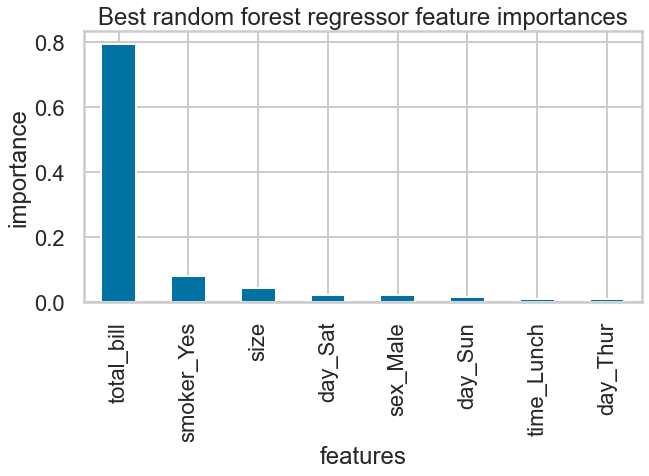

In [25]:
plt.subplots(figsize=(10, 5))
imps = tip_rf_grid.best_estimator_.named_steps.randomforestregressor.feature_importances_
rf_feat_imps = pd.Series(imps, index=X_train.columns).sort_values(ascending=False)
rf_feat_imps.plot(kind='bar')
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Best random forest regressor feature importances');

It looks like `total_bill` is by far the most important feature in our Random Forest regression model.

### 3c. Model selection<a id='3c._Model_Selection'></a>

In [11]:
X_cols = [col for col in df.columns if col not in ['tip','perc']]

X = df[X_cols]
y = df['tip']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

X_train = X_train.sample(10000, random_state=42, replace=True)
y_train = y_train.sample(10000, random_state=42, replace=True)
X_test = X_test.sample(1000, random_state=42, replace=True)
y_test = y_test.sample(1000, random_state=42, replace=True)

lr_neg_mae = cross_validate(tip_lr_grid.best_estimator_, X_train, y_train, 
                            scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)
lr_mae_mean = np.mean(-1 * lr_neg_mae['test_score'])
lr_mae_std = np.std(-1 * lr_neg_mae['test_score'])
lr_mae_mean, lr_mae_std

(0.7697346035384776, 0.009126391124890993)

In [12]:
mean_absolute_error(y_test, tip_lr_grid.best_estimator_.fit(X_train, y_train).predict(X_test))

0.5992287997370922

In [25]:
mean_absolute_error(y_train, tip_lr_grid.best_estimator_.fit(X_train, y_train).predict(X_train))

0.7318348772313142

In [26]:
mean_absolute_error(y_train, tip_rf_grid.best_estimator_.fit(X_train, y_train).predict(X_train))

2.9687363678476685e-16

The mean absolute error for our linear regression model is **~0.60**.

In [13]:
rf_neg_mae = cross_validate(tip_rf_grid.best_estimator_, X_train, y_train, 
                            scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)
rf_mae_mean = np.mean(-1 * rf_neg_mae['test_score'])
rf_mae_std = np.std(-1 * rf_neg_mae['test_score'])
rf_mae_mean, rf_mae_std

(2.8839153287663065e-16, 1.0601694001420618e-17)

In [14]:
mean_absolute_error(y_test, tip_rf_grid.best_estimator_.fit(X_train, y_train).predict(X_test))

0.7939150000000001

The mean absolute error for our Random Forest regression model is **~0.79**, making it inferior to the linear regression model. As such, we will go with our Linear Regression model to predict `tip`.

## 4. Model Evaluations<a id='5._Model_Evaluations'></a>

### 4a. Evaluation scatterplots<a id='5a._Evaluation_scatterplots'></a>

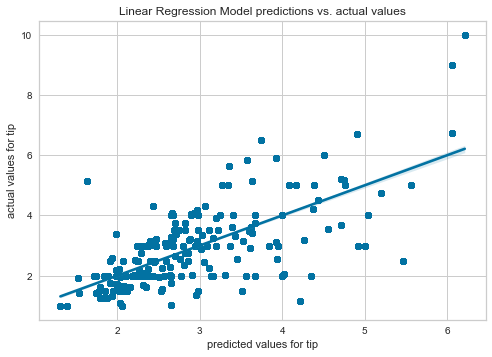

In [21]:
model = tip_lr_grid.fit(X_train, y_train)
y_pred = model.predict(X_train)

_ = sns.regplot(x=y_pred, y=y_train, fit_reg = True)
_ = plt.xlabel('predicted values for tip')
_ = plt.ylabel('actual values for tip')
_ = plt.title('Linear Regression Model predictions vs. actual values')

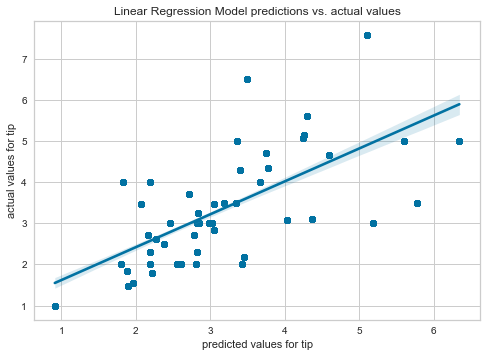

In [20]:
model = tip_lr_grid.fit(X_train, y_train)
y_pred = model.predict(X_test)

_ = sns.regplot(x=y_pred, y=y_test, fit_reg = True)
_ = plt.xlabel('predicted values for tip')
_ = plt.ylabel('actual values for tip')
_ = plt.title('Linear Regression Model predictions vs. actual values')

Visually, it looks like our Linear Regression model for `tip` has a weak correlation.

### 4b. R-Squared<a id='5b._R-Squared'></a>

In [16]:
model.score(X_test, y_test)

0.4476048724115359

Our 2 Linear regression model has an $R^{2}$ of **0.45**, which means only about **45%** of the variance in tips can be explained by our model.

### 4c. Residuals plots<a id='4c._Residuals_plots'></a>

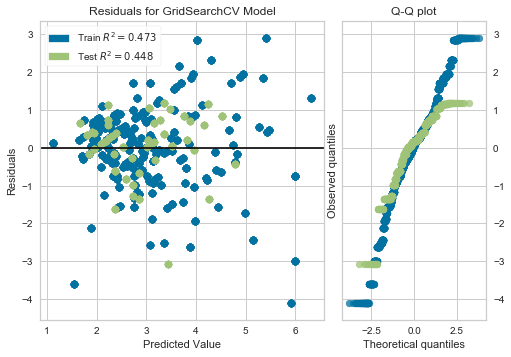

In [17]:
visualizer = ResidualsPlot(model, hist=False, qqplot=True)

_ = visualizer.fit(X_train, y_train) 
_ = visualizer.score(X_test, y_test) 
_ = visualizer.show()  

The residuals plot shows a mostly normal distribution of data points, with a little bit of homoscedascity. The QQ plot shows a little skew on the tails, which means the predicted values are a little more extreme on the minimum and maximum values. 

### 4d. Comparison with simple model based on mean<a id='4d._Comparison_with_simple_model_based_on_mean'></a>

Our multivariate linear regression model seems to be a lot better at predicting tip amounts than tip percentages. The $R^{2}$ for both models is not very high either. In order to make sure our model is even decent, we should compare with a simple model in which we take only the mean of **y_train** and predict that all values of **y_test** will be that mean. If our models have significantly lower mean absolute errors as compared to this model, then we at least know we are on the right path.

Mean percent improvement: 25.43%


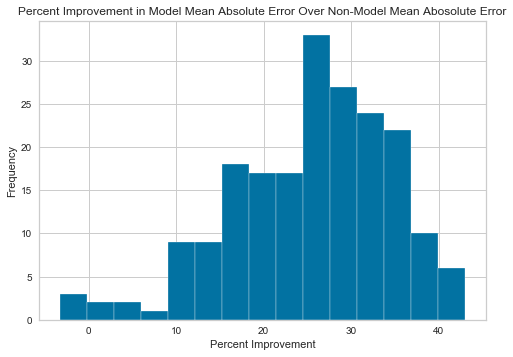

In [18]:
model_mae = []
mean_mae = []

for n in range(200):
    X_cols = [col for col in df.columns if col not in ['tip','perc']]

    X = df[X_cols]
    y = df['tip']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    X_train = X_train.sample(10000, random_state=42, replace=True)
    y_train = y_train.sample(10000, random_state=42, replace=True)
    X_test = X_test.sample(1000, random_state=42, replace=True)
    y_test = y_test.sample(1000, random_state=42, replace=True)
    
    mean = pd.Series(np.array([np.mean(y_train) for n in range(1000)]))

    model_mae.append(mean_absolute_error(y_test, tip_lr_grid.best_estimator_.fit(X_train, y_train).predict(X_test)))
    mean_mae.append(mean_absolute_error(y_test, mean))
    
    model_improvement = [(((meanmae - modelmae)/meanmae) * 100) for modelmae, meanmae in zip(model_mae, mean_mae)]
    
print('Mean percent improvement: ' + str(round((np.mean(model_improvement)), 2)) + '%')

_ = plt.hist(model_improvement, bins=15)
_ = plt.title('Percent Improvement in Model Mean Absolute Error Over Non-Model Mean Abosolute Error')
_ = plt.xlabel('Percent Improvement')
_ = plt.ylabel('Frequency')

With a mean improvement of **25.43%**, our Linear Regression model is significantly stronger than a model based only on the mean of the training set `tip` values. Even though the $R^{2}$ value is low, we are at least on the right path.

# 5. Conclusion and Future Work<a id='6._Conclusion_and_Future_Work'></a>

After bootstrapping a large number of samples from our original dataset, I was able to fit a predictive model to predict `tip` amounts using a Linear Regression model. My model had a $R^{2}$ values of 0.45, meaning 45% of the variance in `tip` amounts can be explained by my model. 

Even though the $R^{2}$ value is low, a **residuals plot** shows that our model provides a decent fit to the data. There is a *slight homoscedascity* to the residuals, but they are, for the most part, uniformly distributed. The **QQ plot** also shows that our errors are nearly normally distributed, with some more extreme values on the tails. Finally, our **mean absolute error** of **$0.60** is not very high. However, this value could be improved.

Our original dataset only contained *244 rows* and only came from one server at one restaurant over the course of a few months. As a result, our model is most likely not generalizable to other restaurants. In order create a more accurate and reliable model, more data will need to be collected. 

In [19]:
new_data = pd.DataFrame.from_dict(
    {'total_bill':[30.00], 
            'size':[2], 
            'sex_Male':[1], 
            'smoker_Yes':[1], 
            'day_Sat':[1], 
            'day_Sun':[0], 
            'day_Thur':[0], 
            'time_Lunch':[0]})
tip_lr_grid.predict(new_data)

array([3.91518522])